In [ ]:
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
import csv
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
%matplotlib inline
import tensorflow as tf
from tensorflow import keras


In [3]:
det_class_path = '../data/RSNA/stage_2_detailed_class_info.csv'
bbox_path = '../data/RSNA/stage_2_train_labels.csv'
dicom_dir = '../data/RSNA/stage_2_train_images/'

# load and shuffle filenames
dicom_dir = '../data/RSNA/stage_2_train_images/'
filenames = os.listdir(dicom_dir)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


In [5]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../data/RSNA/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

30227 class infos loaded
26684 patient cases


,patientId,class
338,06efb50a-e30e-4e44-b323-c228c66d80a6,Lung Opacity
28707,fde7bf44-9cb7-4506-9738-5774d4547f6f,Lung Opacity
10882,72831387-4c1f-4398-a638-803ad559e2fd,No Lung Opacity / Not Normal


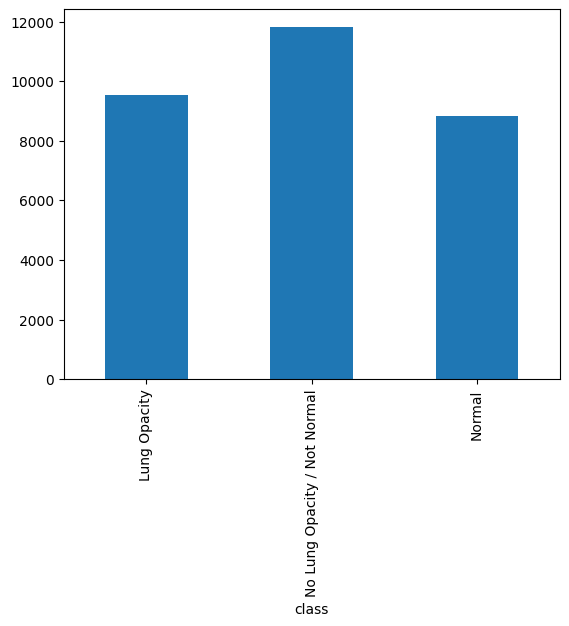

In [6]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [7]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
25399,e3a1a1c3-bb46-4ba9-aec9-7b59b96cd728,NaN,NaN,NaN,NaN,0
4914,42705f2c-8bdc-4a9d-8e13-864b0a89be21,265.0,476.0,163.0,239.0,1
21199,bfe43bfd-5d99-4216-83da-f0e6e918fe28,NaN,NaN,NaN,NaN,0


In [8]:
# we first try a join and see that it doesn't work (we end up with too many boxes)
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

37629 combined cases


In [9]:
comb_bbox_df = pd.concat([bbox_df,
                        det_class_df.drop('patientId',axis=1)], axis=1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
18338,ad446933-fb8e-4739-bb40-2063e796ffd8,NaN,NaN,NaN,NaN,0,Normal
28995,001031d9-f904-4a23-b3e5-2c088acd19c6,552.0,164.0,376.0,676.0,1,Lung Opacity
7410,56bd9bed-4162-43d9-a3f8-dfdacfeb78e9,NaN,NaN,NaN,NaN,0,Normal


In [10]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [11]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [12]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

26684 images found


In [13]:
image_bbox_df = pd.merge(comb_box_df,
                         image_df,
                         on='patientId',
                        how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../data/RSNA/stage_2_train_images\0004cfab-14f...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../data/RSNA/stage_2_train_images\000924cf-0f8...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../data/RSNA/stage_2_train_images\000db696-cf5...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../data/RSNA/stage_2_train_images\000db696-cf5...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../data/RSNA/stage_2_train_images\000fe35a-264...


,BodyPartExamined,ViewPosition,PatientSex
count,26684,26684,26684
unique,1,2,2
top,CHEST,PA,M
freq,26684,14511,15166


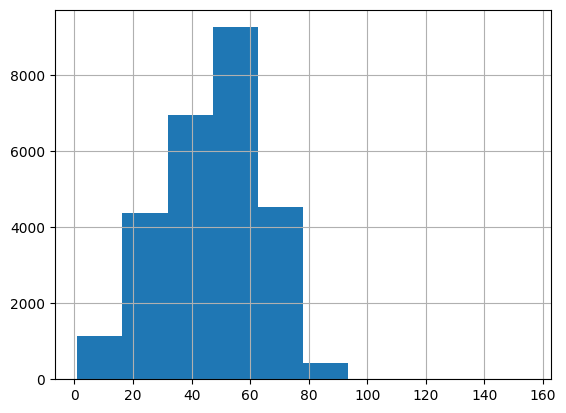

In [14]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.dcmread(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '')
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',axis=1).describe(exclude=np.number)

In [15]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')

In [16]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15404\476809144.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_bbox_df.\


,patientId,x,y,width,height,Target,class,boxes,path
0,d75b355b-5d62-4d34-96d9-0b012727f703,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../data/RSNA/stage_2_train_images\d75b355b-5d6...
1,7f86ef64-225c-44ba-a1ab-e4ec82945ff0,NaN,NaN,NaN,NaN,0,Normal,1,../data/RSNA/stage_2_train_images\7f86ef64-225...
2,b0958738-73d0-47d5-9703-0de86944e0da,421.0,509.0,157.0,234.0,1,Lung Opacity,1,../data/RSNA/stage_2_train_images\b0958738-73d...
3,335e0c90-7426-44a3-a9c3-11b21485d840,157.0,490.0,302.0,355.0,1,Lung Opacity,2,../data/RSNA/stage_2_train_images\335e0c90-742...
4,335e0c90-7426-44a3-a9c3-11b21485d840,595.0,306.0,276.0,412.0,1,Lung Opacity,2,../data/RSNA/stage_2_train_images\335e0c90-742...
5,a4d40476-66d3-4733-9db5-63b4fd7215a8,581.0,592.0,213.0,230.0,1,Lung Opacity,3,../data/RSNA/stage_2_train_images\a4d40476-66d...
6,a4d40476-66d3-4733-9db5-63b4fd7215a8,286.0,326.0,167.0,216.0,1,Lung Opacity,3,../data/RSNA/stage_2_train_images\a4d40476-66d...
7,a4d40476-66d3-4733-9db5-63b4fd7215a8,306.0,630.0,206.0,187.0,1,Lung Opacity,3,../data/RSNA/stage_2_train_images\a4d40476-66d...
8,ee820aa5-4804-4984-97b3-f0a71d69702f,605.0,228.0,154.0,223.0,1,Lung Opacity,4,../data/RSNA/stage_2_train_images\ee820aa5-480...
9,ee820aa5-4804-4984-97b3-f0a71d69702f,634.0,569.0,193.0,175.0,1,Lung Opacity,4,../data/RSNA/stage_2_train_images\ee820aa5-480...


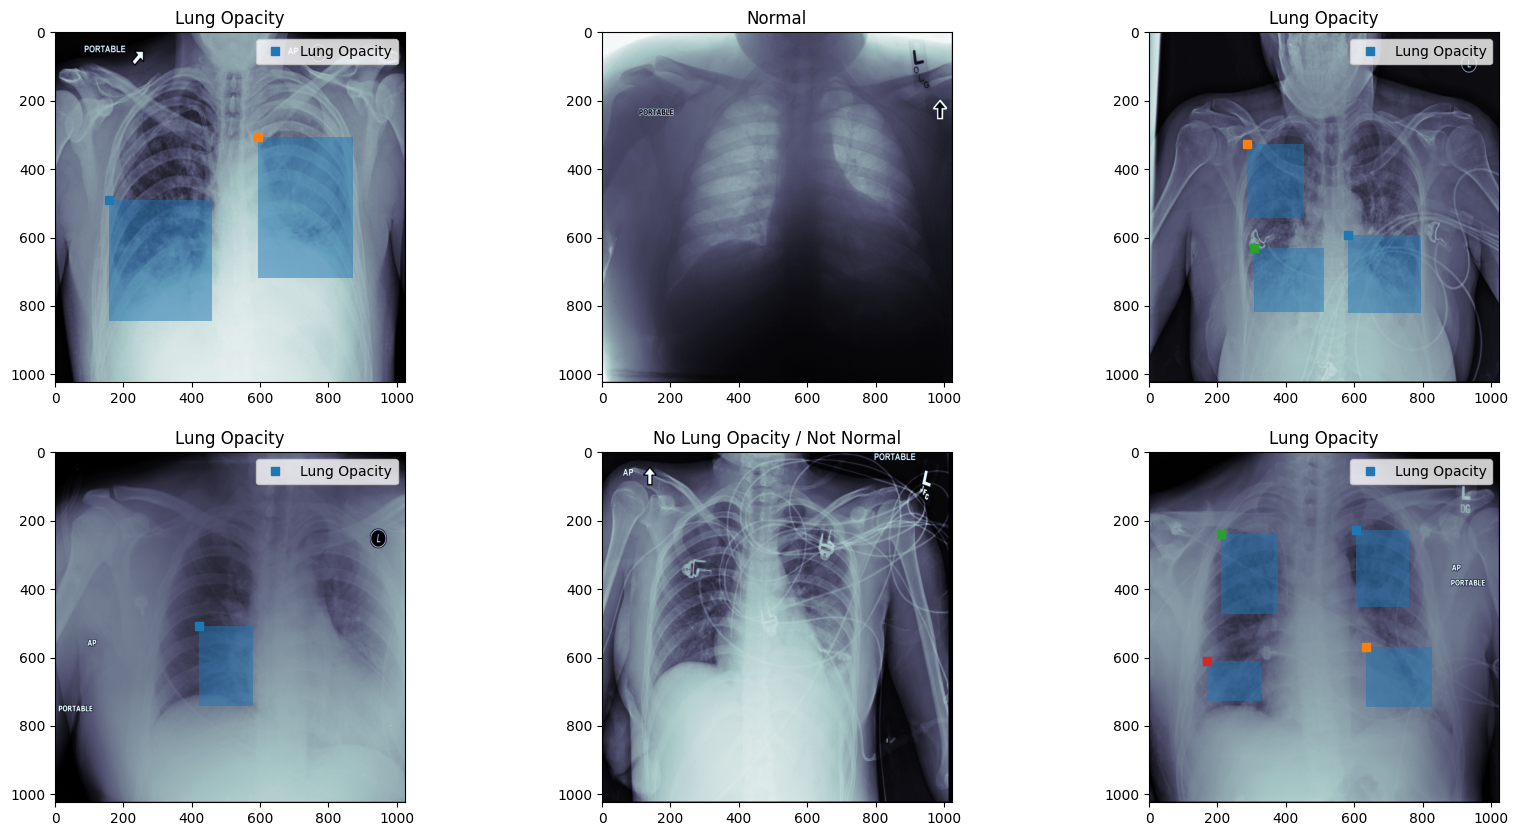

In [17]:
fig, m_axs = plt.subplots(2, 3, figsize=(20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(), sample_df.groupby(['path'])):
    c_path_str = c_path if isinstance(c_path, str) else c_path[0]
    c_dicom = pydicom.dcmread(c_path_str)

    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0, :]))

    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                 width=c_row['width'],
                                 height=c_row['height'],
                                 alpha=0.5))
        if i == 0:
            c_ax.legend()

<AxesSubplot: xlabel='x', ylabel='y'>

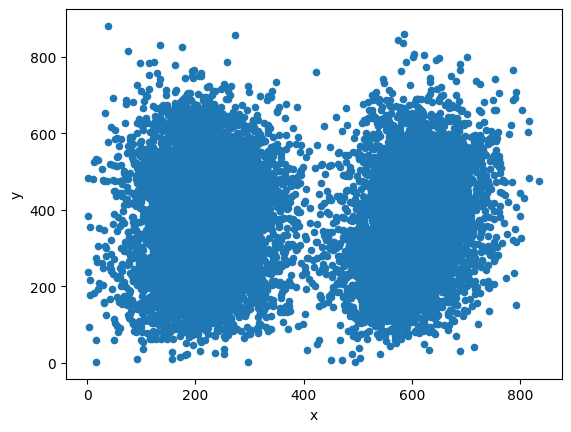

In [18]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

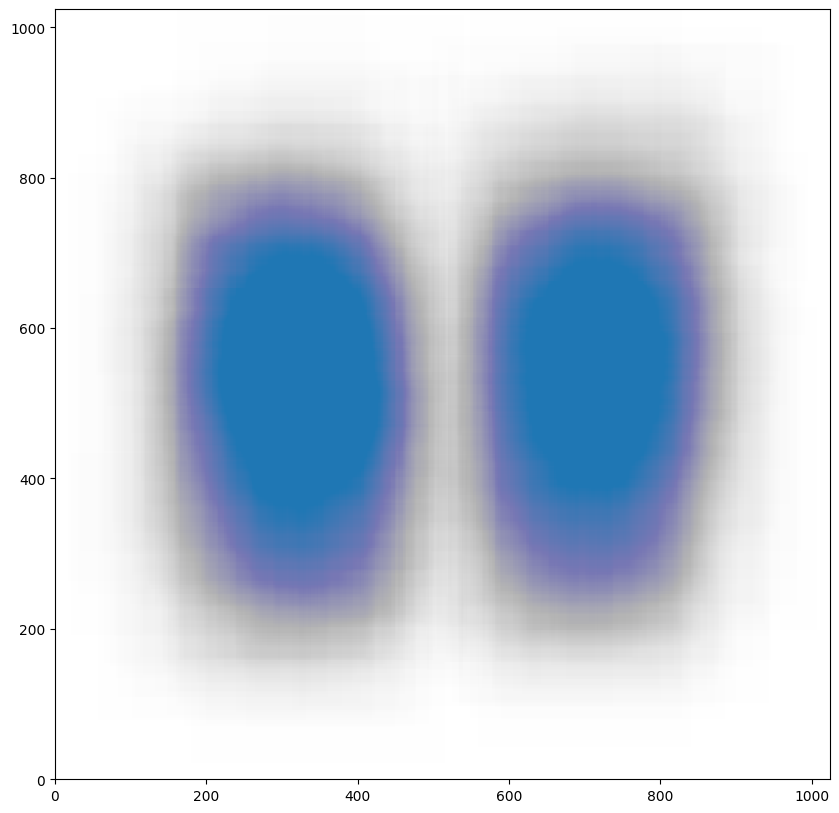

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

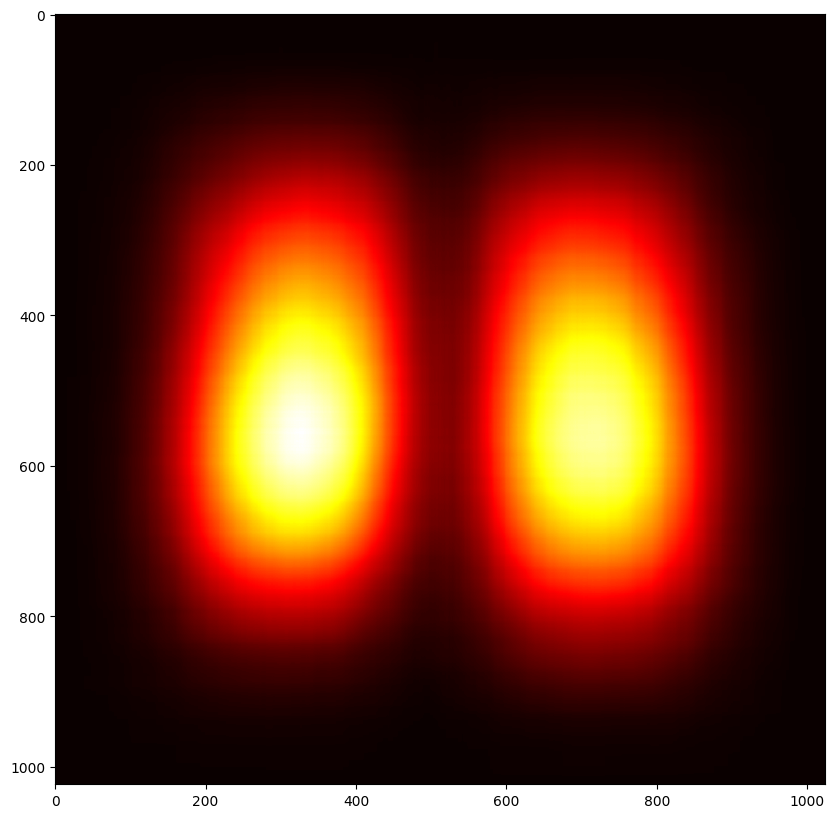

In [20]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS),
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

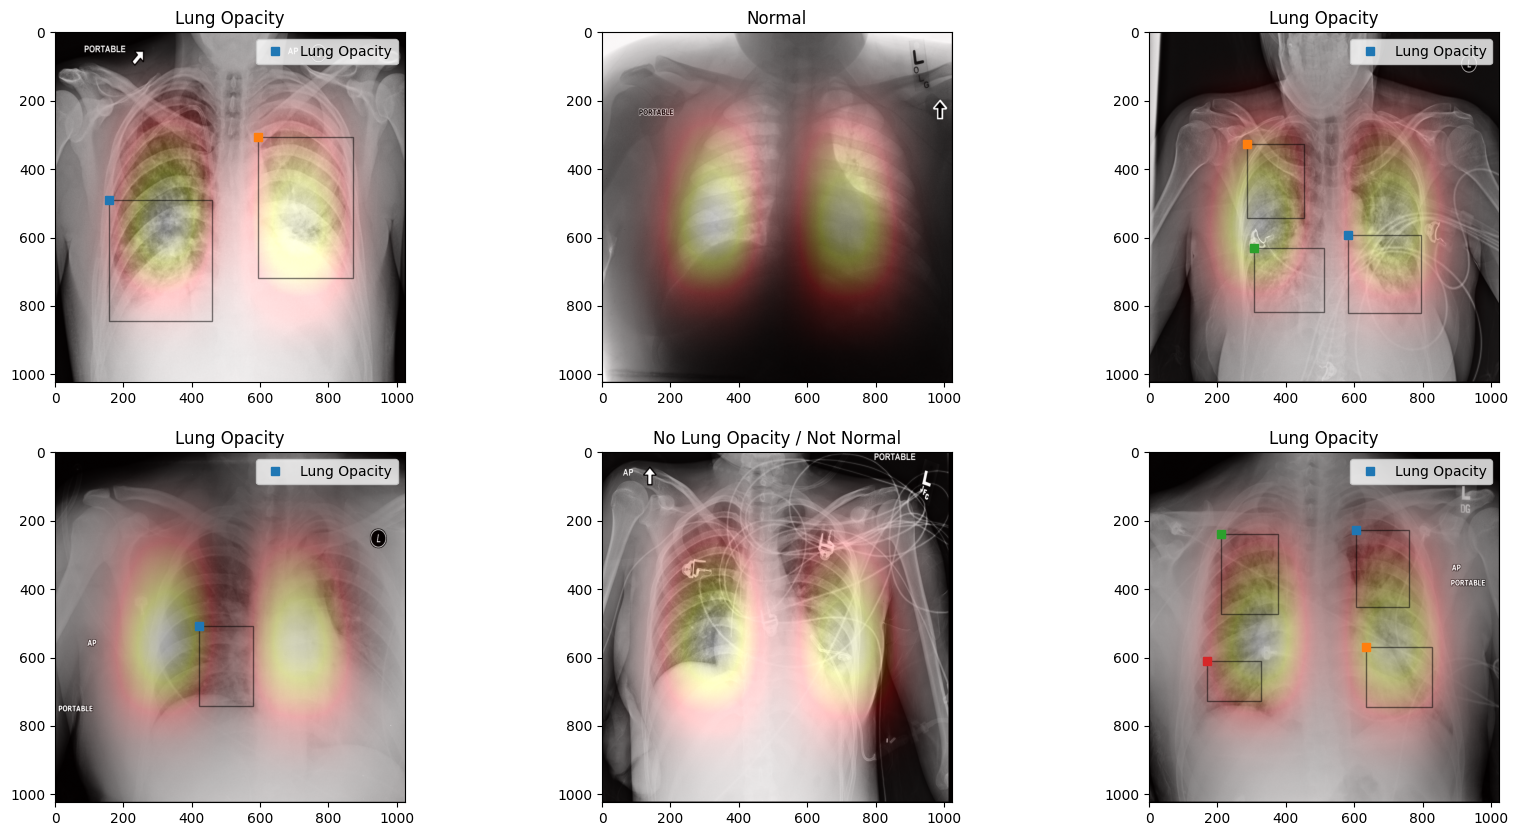

In [21]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_path_str = c_path if isinstance(c_path, str) else c_path[0]
    c_img_arr = pydicom.dcmread(c_path_str).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)

    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'],
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', dpi = 600)

In [22]:
image_bbox_df.to_csv('image_bbox_full.csv', index=False)